<a href="https://colab.research.google.com/github/FMagnani/Physics_Informed_NeuralNetwork/blob/main/Schrodinger_Discrete/TF1_Schrodinger_Discrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code by Raissi adapted to the case of **Schrodinger discrete time model**.  
Adapted from the case of Allen-Cahn discrete time model.  
**Tensorflow 1**  


# Requirements

Cloning GitHub repo 

In [ ]:
!git clone https://github.com/maziarraissi/PINNs.git

Cloning into 'PINNs'...
remote: Enumerating objects: 741, done.
remote: Total 741 (delta 0), reused 0 (delta 0), pack-reused 741
Receiving objects: 100% (741/741), 474.47 MiB | 22.10 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Checking out files: 100% (561/561), done.


Move to the directory for the Allen-Cahn discrete time model

In [ ]:
cd PINNs/main/discrete_time_inference (AC)/

/content/PINNs/main/discrete_time_inference (AC)


#Class definition

Importing, using TF1

In [ ]:

import sys
sys.path.insert(0, '../../Utilities/')

%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


TensorFlow 1.x selected.


Class definition - LBFGS SET TO 500

In [ ]:

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, x1, layers, dt, lb, ub, q):
        
        self.lb = lb
        self.ub = ub
        
        self.x0 = x0
        self.x1 = x1
        
        self.u0 = u0
        self.v0 = v0
        
        self.layers = layers
        self.dt = dt
        self.q = max(q,1)
    
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Load IRK weights
        tmp = np.float32(np.loadtxt('../../Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        self.IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
        self.IRK_times = tmp[q**2+q:]
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x0_tf = tf.placeholder(tf.float32, shape=(None, self.x0.shape[1]))
        self.x1_tf = tf.placeholder(tf.float32, shape=(None, self.x1.shape[1]))
        self.u0_tf = tf.placeholder(tf.float32, shape=(None, self.u0.shape[1]))
        self.v0_tf = tf.placeholder(tf.float32, shape=(None, self.v0.shape[1]))
        self.dummy_x0_tf = tf.placeholder(tf.float32, shape=(None, self.q)) # dummy variable for fwd_gradients
        self.dummy_x1_tf = tf.placeholder(tf.float32, shape=(None, self.q+1)) # dummy variable for fwd_gradients
        
        self.U0_pred, self.V0_pred = self.net_UV0(self.x0_tf) # N x (q+1)
        self.U1_pred,self.V1_pred, self.U1_x_pred,self.V1_x_pred = self.net_UV1(self.x1_tf) # N1 x (q+1)
        
        self.loss = tf.reduce_sum(tf.square(self.u0_tf - self.U0_pred)) + tf.reduce_sum(tf.square(self.v0_tf - self.V0_pred)) + tf.reduce_sum(tf.square(self.U1_pred[0,:] - self.U1_pred[1,:])) + tf.reduce_sum(tf.square(self.U1_x_pred[0,:] - self.U1_x_pred[1,:])) + tf.reduce_sum(tf.square(self.V1_pred[0,:] - self.V1_pred[1,:])) + tf.reduce_sum(tf.square(self.V1_x_pred[0,:] - self.V1_x_pred[1,:]))

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 500,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)

        # The output is q+1 items referring to U plus q+1 items referring to V
        # It's parsed and returned already divided into two arrays
        length = int(Y.shape[1])
        half_len = int(length*0.5)
        U = Y[:, :half_len]
        V = Y[:, half_len:]

        return U, V
    
    def fwd_gradients_0(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x0_tf)[0]
        return tf.gradients(g, self.dummy_x0_tf)[0]
    
    def fwd_gradients_1(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x1_tf)[0]
        return tf.gradients(g, self.dummy_x1_tf)[0]
    
    def net_UV0(self, x):
        U1, V1 = self.neural_net(x, self.weights, self.biases)
        U = U1[:,:-1]
        V = V1[:,:-1]
        U_x = self.fwd_gradients_0(U, x)
        U_xx = self.fwd_gradients_0(U_x, x)
        V_x = self.fwd_gradients_0(V, x)
        V_xx = self.fwd_gradients_0(V_x, x)
        F_u = -0.5*V_xx - (U**2 + V**2)*V
        F_v = +0.5*U_xx + (U**2 + V**2)*U
        U0 = U1 - self.dt*tf.matmul(F_u, self.IRK_weights.T)
        V0 = V1 - self.dt*tf.matmul(F_v, self.IRK_weights.T)
        return U0, V0

    def net_UV1(self, x):
        U1, V1 = self.neural_net(x, self.weights, self.biases)
        U1_x = self.fwd_gradients_1(U1, x)
        V1_x = self.fwd_gradients_1(V1, x)
        return U1,V1, U1_x,V1_x # N x (q+1)
    
    def callback(self, loss):
        print('Loss:', loss)
    
    def train(self, nIter):
        tf_dict = {self.x0_tf: self.x0, self.u0_tf: self.u0, self.v0_tf: self.v0, self.x1_tf: self.x1,
                   self.dummy_x0_tf: np.ones((self.x0.shape[0], self.q)),
                   self.dummy_x1_tf: np.ones((self.x1.shape[0], self.q+1))}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
    
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
    
    def predict(self, x_star):
        
        U1_star = self.sess.run(self.U1_pred, {self.x1_tf: x_star})
        V1_star = self.sess.run(self.V1_pred, {self.x1_tf: x_star})
                   
        return U1_star, V1_star


#Plotting function definition

Function definition

In [ ]:

def plot_slice(ax, Exact_h,h_pred, idx_t1, x,t, title):
    
    title = title+', t = '+str(t[idx_t1])[1:5]

    ax.plot(x,Exact_h[idx_t1,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,h_pred, 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
#    ax.set_ylabel('$|h(t,x)|$')    
    ax.set_title(title, fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,5.1])

    return ax
    

#Data preparation and model initialization

In [ ]:

np.random.seed(1234)
tf.set_random_seed(1234)

if __name__ == "__main__": 
        
    q = 100
    layers = [1, 200, 200, 200, 200, 2*(q+1)]
    lb = np.array([-5.0])
    ub = np.array([5.0])
    
    # Reduced training data since the validation set is reduced too
    N = 150
    
    data = scipy.io.loadmat('../Data/NLS.mat')
    
    t = data['tt'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = data['uu']
    Exact_u = np.real(Exact).T
    Exact_v = np.imag(Exact).T
    Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
    
    # t slices: 75, 100, 125
    idx_t0 = 0
    idx_t1 = 75
    dt = t[idx_t1] - t[idx_t0]

    idx_x = np.random.choice(Exact_u.shape[1], N, replace=False)   
    # Initial data - u
    noise_u0 = 0.0
    x0 = x[idx_x,:]
    u0 = Exact_u[idx_t0:idx_t0+1,idx_x].T
    u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])
    # Initial data - v
    noise_v0 = 0.0
    x0 = x[idx_x,:]
    v0 = Exact_v[idx_t0:idx_t0+1,idx_x].T
    v0 = v0 + noise_v0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1]) 
       
    # Boundary data
    x1 = np.vstack((lb,ub))
    
    # Test data
    x_star = x

    # Conversion to tensors    
#    x0 = tf.convert_to_tensor(x0)
#    u0 = tf.convert_to_tensor(u0)
#    v0 = tf.convert_to_tensor(v0)
#    x_star = tf.convert_to_tensor(x_star)

    model = PhysicsInformedNN(x0, u0, v0, x1, layers, dt, lb, ub, q)
   

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#First slice (dt = 0.58)

## Training

Super fast training: 100 Adam opt + 100 LBFGS opt  
dt = 0.58

In [ ]:
model.train(100)

It: 0, Loss: 1.159e+04, Time: 1.25
It: 10, Loss: 6.571e+03, Time: 0.20
It: 20, Loss: 6.395e+03, Time: 0.17
It: 30, Loss: 6.106e+03, Time: 0.18
It: 40, Loss: 6.018e+03, Time: 0.17
It: 50, Loss: 5.721e+03, Time: 0.17
It: 60, Loss: 3.088e+03, Time: 0.20
It: 70, Loss: 1.115e+03, Time: 0.18
It: 80, Loss: 7.192e+02, Time: 0.18
It: 90, Loss: 4.789e+02, Time: 0.17
Loss: 385.60068
Loss: 422882.88
Loss: 385.25565
Loss: 384.46234
Loss: 382.82214
Loss: 379.57388
Loss: 374.8681
Loss: 365.5703
Loss: 378.3487
Loss: 361.272
Loss: 354.41776
Loss: 352.66434
Loss: 351.53348
Loss: 348.96857
Loss: 341.8263
Loss: 332.0748
Loss: 322.4053
Loss: 314.05673
Loss: 309.12936
Loss: 301.95294
Loss: 288.98175
Loss: 294.15723
Loss: 284.25122
Loss: 278.85315
Loss: 275.36337
Loss: 270.33102
Loss: 262.5573
Loss: 256.12952
Loss: 243.20322
Loss: 234.34018
Loss: 229.2234
Loss: 222.38896
Loss: 214.17108
Loss: 205.17531
Loss: 197.99309
Loss: 191.85135
Loss: 183.54166
Loss: 170.20186
Loss: 156.206
Loss: 144.40117
Loss: 137.395

Prediction

In [ ]:
U1_pred, V1_pred = model.predict(x_star)
h_pred = np.sqrt(U1_pred[:, -1:]**2 + V1_pred[:, -1:]**2)

error_u = np.linalg.norm(U1_pred[:,-1] - Exact_u[idx_t1,:], 2)/np.linalg.norm(Exact_u[idx_t1,:], 2)
error_v = np.linalg.norm(V1_pred[:,-1] - Exact_v[idx_t1,:], 2)/np.linalg.norm(Exact_v[idx_t1,:], 2)
error_h = np.linalg.norm(h_pred - Exact_h[idx_t1,:], 2)/np.linalg.norm(Exact_h[idx_t1,:], 2)
print('Error: %e' % (error_u))
print('Error: %e' % (error_v))
print('Error: %e' % (error_h))


Error: 3.094072e-01
Error: 1.696483e-01
Error: 1.258709e+01


##Plotting

Plotting

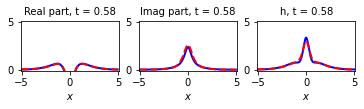

In [ ]:

    ###    PLOTTING    ###
    
fig, [ax_u, ax_v, ax_h] = plt.subplots(1,3)
    
plot_slice(ax_u, Exact_u,U1_pred[:,-1:], idx_t1, x_star,t, 'Real part')
plot_slice(ax_v, Exact_v,V1_pred[:,-1:], idx_t1, x_star,t, 'Imag part')
plot_slice(ax_h, Exact_h,h_pred, idx_t1, x_star,t, 'h')
plt.show()


# Second slice (dt = 0.78)


Second slice: dt = 0.78

In [ ]:
idx_t0 = 0
idx_t1 = 100
dt = t[idx_t1] - t[idx_t0]

model = PhysicsInformedNN(x0, u0, v0, x1, layers, dt, lb, ub, q)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



## Training

Training: 1000 Adam opt + 1000 LBFGS opt  
dt = 0.78  
Time taken for the training: ~ 5m

In [ ]:
model.train(1000)

It: 0, Loss: 1.161e+04, Time: 1.45
It: 10, Loss: 6.707e+03, Time: 0.17
It: 20, Loss: 6.378e+03, Time: 0.18
It: 30, Loss: 6.114e+03, Time: 0.17
It: 40, Loss: 6.047e+03, Time: 0.17
It: 50, Loss: 5.908e+03, Time: 0.18
It: 60, Loss: 4.649e+03, Time: 0.19
It: 70, Loss: 1.173e+03, Time: 0.17
It: 80, Loss: 1.084e+03, Time: 0.18
It: 90, Loss: 6.614e+02, Time: 0.17
It: 100, Loss: 5.238e+02, Time: 0.18
It: 110, Loss: 4.575e+02, Time: 0.18
It: 120, Loss: 4.177e+02, Time: 0.18
It: 130, Loss: 3.853e+02, Time: 0.18
It: 140, Loss: 3.563e+02, Time: 0.18
It: 150, Loss: 3.270e+02, Time: 0.17
It: 160, Loss: 2.956e+02, Time: 0.18
It: 170, Loss: 3.043e+02, Time: 0.17
It: 180, Loss: 2.376e+02, Time: 0.18
It: 190, Loss: 2.104e+02, Time: 0.17
It: 200, Loss: 1.867e+02, Time: 0.18
It: 210, Loss: 1.682e+02, Time: 0.18
It: 220, Loss: 1.531e+02, Time: 0.18
It: 230, Loss: 1.412e+02, Time: 0.18
It: 240, Loss: 1.310e+02, Time: 0.19
It: 250, Loss: 1.219e+02, Time: 0.17
It: 260, Loss: 1.134e+02, Time: 0.18
It: 270, Los

Prediction

In [ ]:
U2_pred, V2_pred = model.predict(x_star)
h2_pred = np.sqrt(U2_pred[:, -1:]**2 + V2_pred[:, -1:]**2)

error_u2 = np.linalg.norm(U2_pred[:,-1] - Exact_u[idx_t1,:], 2)/np.linalg.norm(Exact_u[idx_t1,:], 2)
error_v2 = np.linalg.norm(V2_pred[:,-1] - Exact_v[idx_t1,:], 2)/np.linalg.norm(Exact_v[idx_t1,:], 2)
error_h2 = np.linalg.norm(h2_pred - Exact_h[idx_t1,:], 2)/np.linalg.norm(Exact_h[idx_t1,:], 2)
print('Error: %e' % (error_u2))
print('Error: %e' % (error_v2))
print('Error: %e' % (error_h2))


Error: 5.521211e-03
Error: 2.138168e-02
Error: 1.341630e+01


##Plotting

Plotting

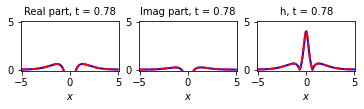

In [ ]:

    ###    PLOTTING    ###
    
fig2, [ax_u, ax_v, ax_h] = plt.subplots(1,3)
    
plot_slice(ax_u, Exact_u,U2_pred[:,-1:], idx_t1, x_star,t, 'Real part')
plot_slice(ax_v, Exact_v,V2_pred[:,-1:], idx_t1, x_star,t, 'Imag part')
plot_slice(ax_h, Exact_h,h2_pred, idx_t1, x_star,t, 'h')
plt.show()


# Third slice (dt = 0.98)

Three trials have been made for computing the third slice, with dt = 0.98.  
The *q parameter*, i.e. the number of Runge-Kutta stages employed, has been set to 100, 150 and 250, but all of these approaches show the same limitation.  
It looks like the code it's not able to correctly predict the third slice... maybe because it's numerically too close to 1?  

## Third slice (dt = 0.98) - 100 RK stages


Third slice: dt = 0.98

In [ ]:
idx_t0 = 0
idx_t1 = 125
dt = t[idx_t1] - t[idx_t0]

model = PhysicsInformedNN(x0, u0, v0, x1, layers, dt, lb, ub, q)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



### Training

Training: 5000 Adam opt + 5000 LBFGS opt  
dt = 0.98  
Time taken for the training: ~ 50m
  
Note: the results are the same for a training of 1000 Adam + 1000 LBFGS, much less time-consuming.  
A good convergence has not been reached. I'll try to increase the RK stages, rather than the training iterations.

In [ ]:
model.train(5000)

Streaming output truncated to the last 5000 lines.
Loss: 0.4029767
Loss: 0.40270042
Loss: 0.402399
Loss: 0.40188017
Loss: 0.40093556
Loss: 0.40683267
Loss: 0.40070504
Loss: 0.4000803
Loss: 0.3995141
Loss: 0.3987314
Loss: 0.39812362
Loss: 0.39863545
Loss: 0.39775196
Loss: 0.3973722
Loss: 0.39693365
Loss: 0.39647883
Loss: 0.3958519
Loss: 0.39606604
Loss: 0.3954549
Loss: 0.394845
Loss: 0.39446878
Loss: 0.39407822
Loss: 0.39337075
Loss: 0.39250946
Loss: 0.3917102
Loss: 0.39118046
Loss: 0.39091206
Loss: 0.39045727
Loss: 0.3902836
Loss: 0.389812
Loss: 0.38929185
Loss: 0.38831574
Loss: 0.38755104
Loss: 0.38701862
Loss: 0.38663656
Loss: 0.38592732
Loss: 0.38549104
Loss: 0.38503516
Loss: 0.384628
Loss: 0.3842068
Loss: 0.38386127
Loss: 0.3834919
Loss: 0.38305032
Loss: 0.38209832
Loss: 0.3819983
Loss: 0.3815608
Loss: 0.38087955
Loss: 0.38038728
Loss: 0.38009554
Loss: 0.37983525
Loss: 0.37956783
Loss: 0.3790391
Loss: 0.37875095
Loss: 0.3781059
Loss: 0.3775754
Loss: 0.3778074
Loss: 0.37730324
Loss:

Prediction

In [ ]:
U3_pred, V3_pred = model.predict(x_star)
h3_pred = np.sqrt(U3_pred[:, -1:]**2 + V3_pred[:, -1:]**2)

error_u3 = np.linalg.norm(U3_pred[:,-1] - Exact_u[idx_t1,:], 2)/np.linalg.norm(Exact_u[idx_t1,:], 2)
error_v3 = np.linalg.norm(V3_pred[:,-1] - Exact_v[idx_t1,:], 2)/np.linalg.norm(Exact_v[idx_t1,:], 2)
error_h3 = np.linalg.norm(h3_pred - Exact_h[idx_t1,:], 2)/np.linalg.norm(Exact_h[idx_t1,:], 2)
print('Error: %e' % (error_u3))
print('Error: %e' % (error_v3))
print('Error: %e' % (error_h3))


Error: 1.953638e+00
Error: 6.643653e-01
Error: 1.285646e+01


###Plotting

Plotting

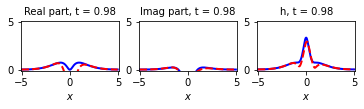

In [ ]:

    ###    PLOTTING    ###
    
fig3, [ax_u, ax_v, ax_h] = plt.subplots(1,3)
    
plot_slice(ax_u, Exact_u,U3_pred[:,-1:], idx_t1, x_star,t, 'Real part')
plot_slice(ax_v, Exact_v,V3_pred[:,-1:], idx_t1, x_star,t, 'Imag part')
plot_slice(ax_h, Exact_h,h3_pred, idx_t1, x_star,t, 'h')
plt.show()


## Third slice (dt = 0.98) - 150 RK stages


Third slice: dt = 0.98

In [ ]:
q = 150
layers = [1, 200, 200, 200, 200, 2*(q+1)]

idx_t0 = 0
idx_t1 = 125
dt = t[idx_t1] - t[idx_t0]

model = PhysicsInformedNN(x0, u0, v0, x1, layers, dt, lb, ub, q)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



### Training

Training: 5000 Adam opt + 1000 LBFGS opt  
dt = 0.98  
Time taken for the training: ~ 15m
  
Note: 

In [ ]:
model.train(5000)

It: 0, Loss: 1.737e+04, Time: 2.13
It: 10, Loss: 1.023e+04, Time: 0.18
It: 20, Loss: 9.548e+03, Time: 0.18
It: 30, Loss: 9.138e+03, Time: 0.18
It: 40, Loss: 9.033e+03, Time: 0.18
It: 50, Loss: 8.714e+03, Time: 0.17
It: 60, Loss: 5.821e+03, Time: 0.17
It: 70, Loss: 1.975e+03, Time: 0.17
It: 80, Loss: 1.558e+03, Time: 0.17
It: 90, Loss: 1.099e+03, Time: 0.18
It: 100, Loss: 9.080e+02, Time: 0.18
It: 110, Loss: 8.177e+02, Time: 0.17
It: 120, Loss: 7.606e+02, Time: 0.17
It: 130, Loss: 7.125e+02, Time: 0.17
It: 140, Loss: 6.761e+02, Time: 0.17
It: 150, Loss: 6.350e+02, Time: 0.19
It: 160, Loss: 5.904e+02, Time: 0.18
It: 170, Loss: 5.464e+02, Time: 0.17
It: 180, Loss: 5.014e+02, Time: 0.17
It: 190, Loss: 4.588e+02, Time: 0.18
It: 200, Loss: 4.346e+02, Time: 0.18
It: 210, Loss: 3.918e+02, Time: 0.18
It: 220, Loss: 3.585e+02, Time: 0.17
It: 230, Loss: 3.284e+02, Time: 0.18
It: 240, Loss: 3.071e+02, Time: 0.18
It: 250, Loss: 3.028e+02, Time: 0.18
It: 260, Loss: 2.812e+02, Time: 0.18
It: 270, Los

Prediction

In [ ]:
U3_pred, V3_pred = model.predict(x_star)
h3_pred = np.sqrt(U3_pred[:, -1:]**2 + V3_pred[:, -1:]**2)

error_u3 = np.linalg.norm(U3_pred[:,-1] - Exact_u[idx_t1,:], 2)/np.linalg.norm(Exact_u[idx_t1,:], 2)
error_v3 = np.linalg.norm(V3_pred[:,-1] - Exact_v[idx_t1,:], 2)/np.linalg.norm(Exact_v[idx_t1,:], 2)
error_h3 = np.linalg.norm(h3_pred - Exact_h[idx_t1,:], 2)/np.linalg.norm(Exact_h[idx_t1,:], 2)
print('Error: %e' % (error_u3))
print('Error: %e' % (error_v3))
print('Error: %e' % (error_h3))


Error: 2.102744e+00
Error: 8.348101e-01
Error: 1.298231e+01


###Plotting

Plotting

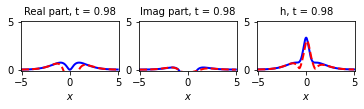

In [ ]:

    ###    PLOTTING    ###
    
fig3, [ax_u, ax_v, ax_h] = plt.subplots(1,3)
    
plot_slice(ax_u, Exact_u,U3_pred[:,-1:], idx_t1, x_star,t, 'Real part')
plot_slice(ax_v, Exact_v,V3_pred[:,-1:], idx_t1, x_star,t, 'Imag part')
plot_slice(ax_h, Exact_h,h3_pred, idx_t1, x_star,t, 'h')
plt.show()


## Third slice (dt = 0.98) - 250 RK stages


Third slice: dt = 0.98

In [ ]:
q = 250
layers = [1, 300, 300, 300, 300, 2*(q+1)]

idx_t0 = 0
idx_t1 = 125
dt = t[idx_t1] - t[idx_t0]

model = PhysicsInformedNN(x0, u0, v0, x1, layers, dt, lb, ub, q)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



### Training

Training: 5000 Adam opt + 1000 LBFGS opt  
dt = 0.98  
Time taken for the training: ~ 18m
  
Note: 

In [ ]:
model.train(5000)

It: 0, Loss: 2.887e+04, Time: 2.34
It: 10, Loss: 1.734e+04, Time: 0.19
It: 20, Loss: 1.557e+04, Time: 0.19
It: 30, Loss: 1.528e+04, Time: 0.20
It: 40, Loss: 1.509e+04, Time: 0.18
It: 50, Loss: 1.484e+04, Time: 0.18
It: 60, Loss: 1.259e+04, Time: 0.18
It: 70, Loss: 3.367e+03, Time: 0.18
It: 80, Loss: 2.834e+03, Time: 0.18
It: 90, Loss: 1.868e+03, Time: 0.18
It: 100, Loss: 1.522e+03, Time: 0.19
It: 110, Loss: 1.353e+03, Time: 0.18
It: 120, Loss: 1.278e+03, Time: 0.19
It: 130, Loss: 1.149e+03, Time: 0.18
It: 140, Loss: 1.115e+03, Time: 0.19
It: 150, Loss: 1.003e+03, Time: 0.18
It: 160, Loss: 9.054e+02, Time: 0.18
It: 170, Loss: 8.174e+02, Time: 0.18
It: 180, Loss: 7.327e+02, Time: 0.19
It: 190, Loss: 6.632e+02, Time: 0.19
It: 200, Loss: 8.043e+02, Time: 0.18
It: 210, Loss: 5.647e+02, Time: 0.18
It: 220, Loss: 5.452e+02, Time: 0.18
It: 230, Loss: 5.095e+02, Time: 0.18
It: 240, Loss: 4.723e+02, Time: 0.19
It: 250, Loss: 4.703e+02, Time: 0.18
It: 260, Loss: 4.221e+02, Time: 0.18
It: 270, Los

Prediction

In [ ]:
U3_pred, V3_pred = model.predict(x_star)
h3_pred = np.sqrt(U3_pred[:, -1:]**2 + V3_pred[:, -1:]**2)

error_u3 = np.linalg.norm(U3_pred[:,-1] - Exact_u[idx_t1,:], 2)/np.linalg.norm(Exact_u[idx_t1,:], 2)
error_v3 = np.linalg.norm(V3_pred[:,-1] - Exact_v[idx_t1,:], 2)/np.linalg.norm(Exact_v[idx_t1,:], 2)
error_h3 = np.linalg.norm(h3_pred - Exact_h[idx_t1,:], 2)/np.linalg.norm(Exact_h[idx_t1,:], 2)
print('Error: %e' % (error_u3))
print('Error: %e' % (error_v3))
print('Error: %e' % (error_h3))


Error: 2.095302e+00
Error: 7.679990e-01
Error: 1.300791e+01


###Plotting

Plotting

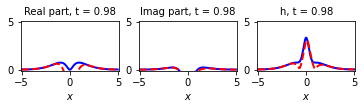

In [ ]:

    ###    PLOTTING    ###
    
fig3, [ax_u, ax_v, ax_h] = plt.subplots(1,3)
    
plot_slice(ax_u, Exact_u,U3_pred[:,-1:], idx_t1, x_star,t, 'Real part')
plot_slice(ax_v, Exact_v,V3_pred[:,-1:], idx_t1, x_star,t, 'Imag part')
plot_slice(ax_h, Exact_h,h3_pred, idx_t1, x_star,t, 'h')
plt.show()


#Final result

Plotting function definition

In [ ]:

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

#%%

def plot_final_results(slice_1,idx_t1,
                       slice_2,idx_t2,
                       slice_3,idx_t3, 
                       Exact,x,t,lb,ub,x_star):
    
    fig, ax = plt.subplots(1,1)
    ax.axis('off')
    
    ####### Row 0: h(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 1)
    gs0.update(top=1-0.06, bottom=1-1/2 + 0.1, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    # True solution on the full domine
    h = ax.imshow(Exact.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[t.min(), t.max(), np.min(x_star), np.max(x_star)], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    # Time lines
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[idx_t1]*np.ones((2,1)), line, 'r--', linewidth = 1)
    ax.plot(t[idx_t2]*np.ones((2,1)), line, 'r--', linewidth = 1)
    ax.plot(t[idx_t3]*np.ones((2,1)), line, 'r--', linewidth = 1)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_title('Exact $h(t,x)$', fontsize = 10)

    ####### Row 1: h(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/2-0.05, bottom=0.15, left=0.15, right=0.85, wspace=0.5)
 
    # First slice
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[idx_t1,:], 'b-', linewidth = 2, label = 'Exact') # True
    ax.plot(x_star, slice_1, 'r--', linewidth = 2, label = 'Prediction') # Data    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$h(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[idx_t1]), fontsize = 10)
    ax.set_xlim([lb-0.1, ub+0.1])
  
    # Second slice
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[idx_t2,:], 'b-', linewidth = 2, label = 'Exact') # True
    ax.plot(x_star, slice_2, 'r--', linewidth = 2, label = 'Prediction') # Pred
    ax.set_xlabel('$x$')
    #ax.set_ylabel('$h(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[idx_t2]), fontsize = 10)    
    ax.set_xlim([lb-0.1, ub+0.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.8, -0.3), ncol=2, frameon=False)

    # Third slice
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact[idx_t3,:], 'b-', linewidth = 2, label = 'Exact') # True
    ax.plot(x_star, slice_3, 'r--', linewidth = 2, label = 'Prediction') # Pred
    ax.set_xlabel('$x$')
    #ax.set_ylabel('$h(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[idx_t3]), fontsize = 10)    
    ax.set_xlim([lb-0.1, ub+0.1])

    return fig
    

Plotting

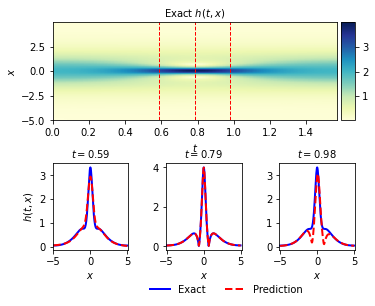

In [ ]:
fig_final = plot_final_results(h_pred,75,
                   h2_pred,100,
                   h3_pred,125, 
                   Exact_h,x,t,lb,ub,x_star)

In [ ]:
fig_final.savefig('Schrodinger_Discrete_results', format='eps')

# Slice at dt = 0.9

I try a slice with dt = 0.9.  
Allen-Cahn with dt = 0.9 can be solved.  

In [ ]:
idx_t0 = 0
idx_t1 = 115
dt = t[idx_t1] - t[idx_t0]

model = PhysicsInformedNN(x0, u0, v0, x1, layers, dt, lb, ub, q)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



## Training

Training: 1500 Adam opt + 500 LBFGS opt  
dt = 0.98  
Time taken for the training: ~ ..m
  
Note: 

In [ ]:
model.train(1500)

It: 0, Loss: 1.160e+04, Time: 1.34
It: 10, Loss: 6.692e+03, Time: 0.41
It: 20, Loss: 6.389e+03, Time: 0.42
It: 30, Loss: 6.102e+03, Time: 0.40
It: 40, Loss: 6.057e+03, Time: 0.40
It: 50, Loss: 5.965e+03, Time: 0.41
It: 60, Loss: 5.495e+03, Time: 0.39
It: 70, Loss: 1.924e+03, Time: 0.40
It: 80, Loss: 1.307e+03, Time: 0.41
It: 90, Loss: 8.204e+02, Time: 0.44
It: 100, Loss: 6.309e+02, Time: 0.41
It: 110, Loss: 5.444e+02, Time: 0.42
It: 120, Loss: 4.950e+02, Time: 0.37
It: 130, Loss: 4.535e+02, Time: 0.41
It: 140, Loss: 4.232e+02, Time: 0.40
It: 150, Loss: 3.816e+02, Time: 0.42
It: 160, Loss: 3.417e+02, Time: 0.40
It: 170, Loss: 3.020e+02, Time: 0.40
It: 180, Loss: 2.786e+02, Time: 0.40
It: 190, Loss: 2.468e+02, Time: 0.43
It: 200, Loss: 2.238e+02, Time: 0.42
It: 210, Loss: 2.014e+02, Time: 0.39
It: 220, Loss: 1.867e+02, Time: 0.40
It: 230, Loss: 1.739e+02, Time: 0.41
It: 240, Loss: 1.616e+02, Time: 0.41
It: 250, Loss: 1.556e+02, Time: 0.42
It: 260, Loss: 1.553e+02, Time: 0.42
It: 270, Los

Prediction

In [ ]:
U_test_pred, V_test_pred = model.predict(x_star)
h_test_pred = np.sqrt(U_test_pred[:, -1:]**2 + V_test_pred[:, -1:]**2)

error_u_test = np.linalg.norm(U_test_pred[:,-1] - Exact_u[idx_t1,:], 2)/np.linalg.norm(Exact_u[idx_t1,:], 2)
error_v_test = np.linalg.norm(V_test_pred[:,-1] - Exact_v[idx_t1,:], 2)/np.linalg.norm(Exact_v[idx_t1,:], 2)
error_h_test = np.linalg.norm(h_test_pred - Exact_h[idx_t1,:], 2)/np.linalg.norm(Exact_h[idx_t1,:], 2)
print('Error: %e' % (error_u_test))
print('Error: %e' % (error_v_test))
print('Error: %e' % (error_h_test))


Error: 7.516539e-01
Error: 3.608736e-01
Error: 1.312485e+01


##Plotting

Plotting

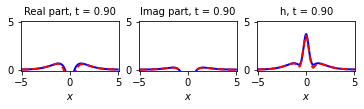

In [ ]:

    ###    PLOTTING    ###
    
fig_test, [ax_u, ax_v, ax_h] = plt.subplots(1,3)
    
plot_slice(ax_u, Exact_u,U_test_pred[:,-1:], idx_t1, x_star,t, 'Real part')
plot_slice(ax_v, Exact_v,V_test_pred[:,-1:], idx_t1, x_star,t, 'Imag part')
plot_slice(ax_h, Exact_h,h_test_pred, idx_t1, x_star,t, 'h')
plt.show()


In [ ]:
fig_test.savefig('dt09_results')